In [1]:
from typing import List
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch
import nltk
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import librosa.display

/usr/local/lib/python3.12/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-04-07 06:02:35.975893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744005755.993349   36206 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744005755.998746   36206 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

import pandas as pd
import numpy as np

In [3]:
pwd

'/home/i/j/work1'

https://gist.github.com/denguir/b21aa66ae7fb1089655dd9de8351a202 cuda

ffmpeg -i Маша\ р1.m4a -acodec pcm_s16le -ar 16000 Masha_p1a.wav

In [4]:
# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("bond005/wav2vec2-large-ru-golos")
model = Wav2Vec2ForCTC.from_pretrained("bond005/wav2vec2-large-ru-golos")

In [10]:
import glob
sounds_in_batch=[]
true_texts_in_batch=[]
search = './records/Masha_p1.wav'
for file in glob.glob(search, recursive=True):
    txtfile=file[:-3]+'txt'
    print(txtfile)
    audio, sr = librosa.load(file, sr=16000)
    sounds_in_batch.append(audio)
    file2 = open(txtfile,"r+", encoding='utf-8')
    true_texts_in_batch.append(' '.join(list(filter(lambda it: it.isalpha(), nltk.wordpunct_tokenize(file2.read())))).lower().replace('ё', 'е'))
    file2.close()
    
    

./records/Masha_p1.txt


In [11]:
sounds_in_batch

[array([0.        , 0.        , 0.        , ..., 0.00048828, 0.00088501,
        0.00018311], dtype=float32)]

In [12]:
true_texts_in_batch

['работа работа радио радио радость радость радуга радуга раз раз рак рак ракета ракета ракетка ракетка раковина раковина рама рама рана рана ранец ранец рассказ рассказ расческа расческа рая рая рожок рожок розетка розетка ромашка ромашка робот робот ровный ровный родина родина рожки рожки роза роза розовый розовый рома рома рот рот роща роща рубанок рубанок рубашка рубашка рубить рубить рука рука рукав рукав рукавица рукавица румянец румянец русский русский русый русый русь русь ручей ручей ручка ручка ручной ручной рыба рыба рыбак рыбак рыбный рыбный рыжик рыжик рынок рынок рысь рысь рыть рыть арба арба арбат арбат арбуз арбуз арка арка аромат аромат артист артист астра астра барабан барабан баран баран баранка баранка баржа баржа бархан бархан бархат бархат бодрость бодрость боровик боровик браво браво брат братбрать брать буран буран буратино буратино быстрый быстрый ведра ведра вера вера воробей воробей выдра выдра гараж гараж гармонь гамонь гитара гитара гора гора град град грам

In [13]:
%%time
processed = processor(sounds_in_batch, sampling_rate=16_000,
                      return_tensors="pt", padding="longest")

CPU times: user 31 ms, sys: 13.3 ms, total: 44.3 ms
Wall time: 41.3 ms


In [21]:
%%time
#if cpu
model     = model.to("cpu")
with torch.no_grad():
    logits = model(processed.input_values, attention_mask=processed.attention_mask,output_hidden_states=True,return_dict=True).logits

CPU times: user 14min 56s, sys: 12 s, total: 15min 8s
Wall time: 4min 18s


In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7e41eaa66250 to Device at 0x7e41ebd1c050>

In [16]:
#!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% | 75% |
|  1 |  0% | 66% |


In [58]:
len(path)

8488

In [17]:
device = "cuda:0"
model     = model.to(device)

In [18]:
%%time
with torch.no_grad():
    ts = model(processed.input_values.cuda(), attention_mask=processed.attention_mask.cuda(), output_hidden_states=True,return_dict=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.05 GiB. GPU 0 has a total capacity of 10.91 GiB of which 437.19 MiB is free. Process 39136 has 8.07 GiB memory in use. Including non-PyTorch memory, this process has 2.40 GiB memory in use. Of the allocated memory 2.24 GiB is allocated by PyTorch, and 5.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
%%time
with torch.no_grad():
    ts = model(processed.input_values, attention_mask=processed.attention_mask, output_hidden_states=True)

In [13]:
last_hidden_state = ts.hidden_states[-1]

In [19]:
logits=ts.logits.cpu()

In [59]:
1

1

In [ ]:
device = "cpu"
model     = model.to(device)

In [ ]:
processed2   = processed.input_values.cuda()
processed2am = processed.attention_mask.cuda()

In [15]:
feat_extract_output_lengths = model._get_feat_extract_output_lengths(processed.attention_mask.sum(dim=1)).numpy()

In [20]:
emission_matrices = []
for sample_idx in range(feat_extract_output_lengths.shape[0]):
    specgram_len = feat_extract_output_lengths[sample_idx]
    new_emission_matrix = torch.log_softmax(
        logits[sample_idx, 0:specgram_len],
        dim=-1
    ).numpy()
    assert len(new_emission_matrix.shape) == 2
    assert new_emission_matrix.shape[0] == specgram_len
    emission_matrices.append(new_emission_matrix)

In [21]:
def get_trellis(emission: np.ndarray, tokens_ids: List[int],
                blank_id: int = 0) -> np.ndarray:
    assert isinstance(emission, np.ndarray)
    assert len(emission.shape) == 2
    num_frame = emission.shape[0]
    num_tokens = len(tokens_ids)
    trellis = np.empty((num_frame + 1, num_tokens + 1), dtype=np.float64)
    trellis[0, 0] = 0
    trellis[1:, 0] = np.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")
    for t in range(num_frame):
        trellis[t + 1, 1:] = np.maximum(
            trellis[t, 1:] + emission[t, blank_id],
            trellis[t, :-1] + emission[t, tokens_ids]
        )
    return trellis

In [23]:
with processor.as_target_processor():
    processedtxt = processor(true_texts_in_batch, padding='longest', return_tensors='pt')
    labels_ = processedtxt.input_ids.masked_fill(
    processedtxt.attention_mask.ne(1),
    -100
)

In [24]:

labels_ = labels_.numpy()
labels = []
for sample_idx in range(labels_.shape[0]):
    new_label_list = []
    for token_idx in range(labels_.shape[1]):
        if labels_[sample_idx, token_idx] < 0:
            break
        new_label_list.append(int(labels_[sample_idx, token_idx]))
    labels.append(new_label_list)
    del new_label_list
del labels_

In [25]:
trellis = get_trellis(emission_matrices[0], labels[0])

In [26]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis: np.ndarray, emission: np.ndarray, tokens_ids: List[int],
              blank_id: int = 0) -> List[Point]:
    j = trellis.shape[1] - 1
    t_start = np.argmax(trellis[:, j])

    path = []
    for t in range(t_start, 0, -1):
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens_ids[j - 1]]

        prob = np.exp(emission[t - 1, tokens_ids[j - 1] if changed > stayed else 0])
        path.append(Point(j - 1, t - 1, prob))
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]

In [27]:
path = backtrack(trellis, emission_matrices[0], labels[0])
for p in path:
    print(p)

Point(token_index=0, time_index=70, score=0.97563416)
Point(token_index=0, time_index=71, score=0.9998473)
Point(token_index=0, time_index=72, score=0.9755161)
Point(token_index=1, time_index=73, score=0.98572874)
Point(token_index=1, time_index=74, score=0.99983394)
Point(token_index=1, time_index=75, score=0.9998462)
Point(token_index=1, time_index=76, score=0.99975103)
Point(token_index=1, time_index=77, score=0.99852645)
Point(token_index=1, time_index=78, score=0.62949103)
Point(token_index=1, time_index=79, score=0.18010624)
Point(token_index=2, time_index=80, score=0.9227902)
Point(token_index=2, time_index=81, score=0.9996947)
Point(token_index=2, time_index=82, score=0.60748297)
Point(token_index=2, time_index=83, score=0.86131257)
Point(token_index=3, time_index=84, score=0.8763305)
Point(token_index=3, time_index=85, score=0.9930269)
Point(token_index=3, time_index=86, score=0.99382776)
Point(token_index=3, time_index=87, score=0.9952468)
Point(token_index=3, time_index=88, 

In [28]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path: List[Point], tokenized: List[str]) -> List[Segment]:
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                tokenized[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score
            )
        )
        i1 = i2
    return segments

In [29]:
segments = merge_repeats(
    path=path,
    tokenized=processor.tokenizer.convert_ids_to_tokens(
        labels[0],
        skip_special_tokens=False
    )
)
for seg in segments:
    print(seg)

р	(0.98): [   70,    73)
а	(0.83): [   73,    80)
б	(0.85): [   80,    84)
о	(0.97): [   84,    90)
т	(0.80): [   90,    95)
а	(0.92): [   95,    99)
|	(0.95): [   99,   127)
р	(0.48): [  127,   129)
а	(0.85): [  129,   137)
б	(0.76): [  137,   141)
о	(0.89): [  141,   148)
т	(0.82): [  148,   154)
а	(0.88): [  154,   158)
|	(0.99): [  158,   187)
р	(0.99): [  187,   191)
а	(0.96): [  191,   199)
д	(0.67): [  199,   202)
и	(1.00): [  202,   208)
о	(0.94): [  208,   213)
|	(0.99): [  213,   247)
р	(0.60): [  247,   250)
а	(0.95): [  250,   258)
д	(0.80): [  258,   261)
и	(0.98): [  261,   267)
о	(0.98): [  267,   273)
|	(0.96): [  273,   297)
р	(0.98): [  297,   301)
а	(0.89): [  301,   310)
д	(0.81): [  310,   313)
о	(0.97): [  313,   318)
с	(0.89): [  318,   323)
т	(0.00): [  323,   324)
ь	(0.04): [  324,   325)
|	(0.95): [  325,   346)
р	(0.74): [  346,   350)
а	(0.91): [  350,   358)
д	(0.77): [  358,   360)
о	(0.87): [  360,   366)
с	(0.86): [  366,   373)
т	(0.01): [  373,   374)


In [30]:
rnumers=[]
bnumers=[]
for index in range(len(segments)):
    #print(f' aa1 {aa1} aa2 {aa2}')
    if segments[index].label=='р':
        for tmpi in range(segments[index].start,segments[index].end):
          if segments[index].score>0.80 :
            rnumers.append(tmpi)   
          else:
            bnumers.append(tmpi)   
    print(segments[index])

р	(0.98): [   70,    73)
а	(0.83): [   73,    80)
б	(0.85): [   80,    84)
о	(0.97): [   84,    90)
т	(0.80): [   90,    95)
а	(0.92): [   95,    99)
|	(0.95): [   99,   127)
р	(0.48): [  127,   129)
а	(0.85): [  129,   137)
б	(0.76): [  137,   141)
о	(0.89): [  141,   148)
т	(0.82): [  148,   154)
а	(0.88): [  154,   158)
|	(0.99): [  158,   187)
р	(0.99): [  187,   191)
а	(0.96): [  191,   199)
д	(0.67): [  199,   202)
и	(1.00): [  202,   208)
о	(0.94): [  208,   213)
|	(0.99): [  213,   247)
р	(0.60): [  247,   250)
а	(0.95): [  250,   258)
д	(0.80): [  258,   261)
и	(0.98): [  261,   267)
о	(0.98): [  267,   273)
|	(0.96): [  273,   297)
р	(0.98): [  297,   301)
а	(0.89): [  301,   310)
д	(0.81): [  310,   313)
о	(0.97): [  313,   318)
с	(0.89): [  318,   323)
т	(0.00): [  323,   324)
ь	(0.04): [  324,   325)
|	(0.95): [  325,   346)
р	(0.74): [  346,   350)
а	(0.91): [  350,   358)
д	(0.77): [  358,   360)
о	(0.87): [  360,   366)
с	(0.86): [  366,   373)
т	(0.01): [  373,   374)


In [31]:
last_hidden_state=last_hidden_state.cpu()

In [41]:
last_hidden_state.shape

torch.Size([1, 8585, 1024])

In [32]:
rhs=[]
for i in rnumers:
    #print(i)
    rhs.append(last_hidden_state[0,i].numpy())
bhs=[]
for i in bnumers:
    #print(i)
    bhs.append(last_hidden_state[0,i].numpy())
    
rdf=pd.DataFrame(rhs)
bdf=pd.DataFrame(bhs)

In [33]:
rdf['a']=1
bdf['a']=0

In [40]:
print(bdf.shape)
print(rdf.shape)


(247, 1025)
(467, 1025)


In [45]:
bdf0=bdf

In [48]:
bdf1=bdf[0:236]
rdf1=rdf[0:409]

In [44]:
bnumers

[127,
 128,
 247,
 248,
 249,
 346,
 347,
 348,
 349,
 441,
 442,
 443,
 541,
 542,
 649,
 650,
 651,
 737,
 738,
 739,
 740,
 1076,
 1077,
 1078,
 1079,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1176,
 1177,
 1178,
 1272,
 1273,
 1386,
 1387,
 1494,
 1495,
 1540,
 1541,
 1542,
 1594,
 1595,
 1596,
 1655,
 1656,
 1657,
 1658,
 1699,
 1700,
 1701,
 1799,
 1800,
 1903,
 1904,
 1957,
 1958,
 1959,
 2015,
 2016,
 2230,
 2335,
 2336,
 2378,
 2379,
 2380,
 2431,
 2628,
 2712,
 2713,
 2714,
 2715,
 2764,
 2765,
 2906,
 2943,
 2944,
 3008,
 3060,
 3061,
 3118,
 3119,
 3258,
 3259,
 3544,
 3591,
 3592,
 3642,
 3688,
 3689,
 3744,
 3793,
 3794,
 3855,
 3911,
 3912,
 3958,
 3959,
 3960,
 4009,
 4010,
 4011,
 4056,
 4057,
 4058,
 4102,
 4103,
 4145,
 4146,
 4147,
 4148,
 4236,
 4237,
 4426,
 4427,
 4527,
 4613,
 4715,
 4910,
 4992,
 5082,
 5083,
 5084,
 5167,
 5168,
 5169,
 5170,
 5171,
 5172,
 5173,
 5258,
 5259,
 5260,
 5261,
 5262,
 5263,
 5577,
 5578,
 5579,
 5580,
 5581,
 5582,
 5583,
 5584,

In [49]:
df=pd.concat([rdf1, bdf1], ignore_index=True)
dfc = df.drop('a', axis=1)
#df.drop('column_name', axis=1, inplace=True)
cc=df['a']

In [ ]:
pip uninstall umap
pip install umap-learn

In [55]:
bdf1.shape

(236, 1025)

/home/i/.local/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (645). n_quantiles is set to n_samples.
  warnings.warn(


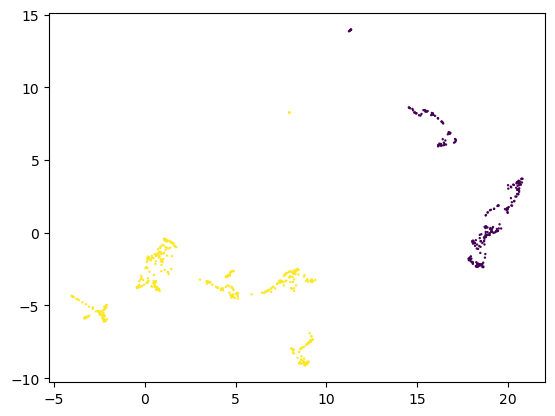

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
import umap.umap_ as umap
#import umap as umap
X=dfc
y=cc
# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
#manifold = umap.fit(X, y)
X_reduced_2 = manifold.transform(X)


# Plot the results
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);


/home/i/.local/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (645). n_quantiles is set to n_samples.
  warnings.warn(


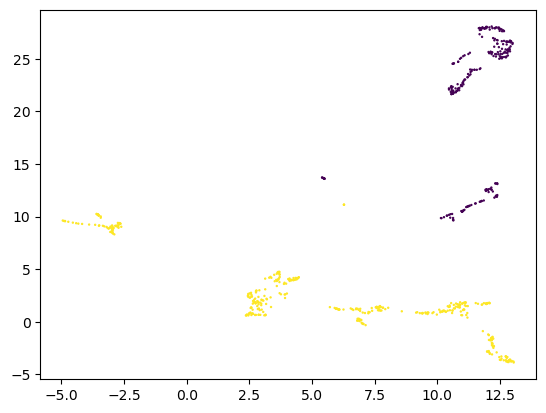

In [81]:
X=dfc
y=cc
# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
#manifold = umap.fit(X, y)
X_reduced_2 = manifold.transform(X)

plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [82]:
import joblib
joblib.dump(manifold, './hor/manifoldflat2')

['./hor/manifoldflat2']

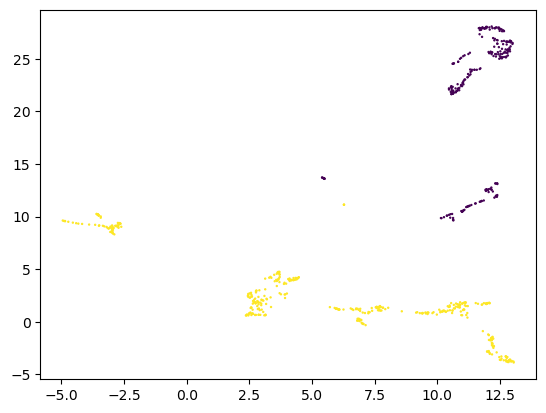

In [87]:
loaded_manifoldb=joblib.load('./hor/manifoldflat2')
fX_reduced_2 = loaded_manifoldb.transform(X)

plt.scatter(fX_reduced_2[:, 0], fX_reduced_2[:, 1], c=y, s=0.5);

/home/i/.local/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (645). n_quantiles is set to n_samples.
  warnings.warn(


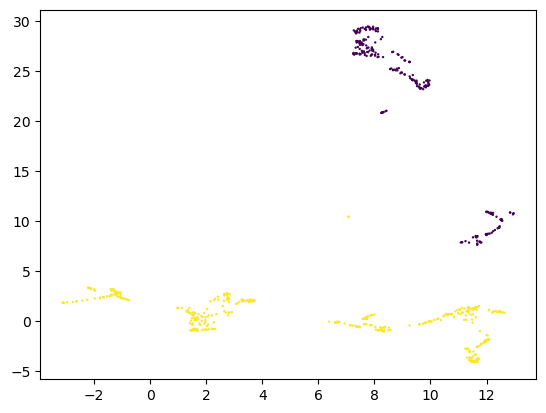

In [88]:
X=dfc
y=cc
# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
#manifold = umap.fit(X, y)
X_reduced_2 = manifold.transform(X)

plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

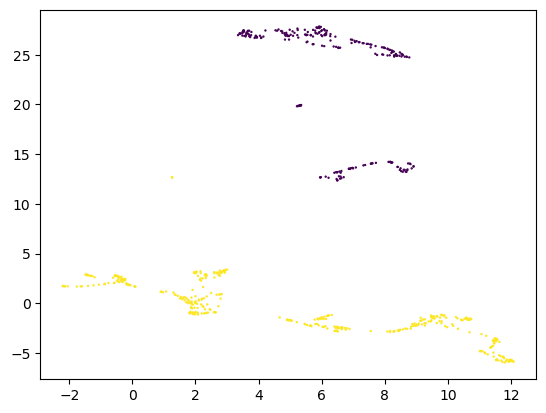

In [96]:
#X=dfc
#y=cc
# Preprocess again
#pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
#X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)

X_reduced_2 = manifold.transform(X)

plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [97]:
joblib.dump(manifold, './hor/manifoldflat_p1')

['./hor/manifoldflat_p1']

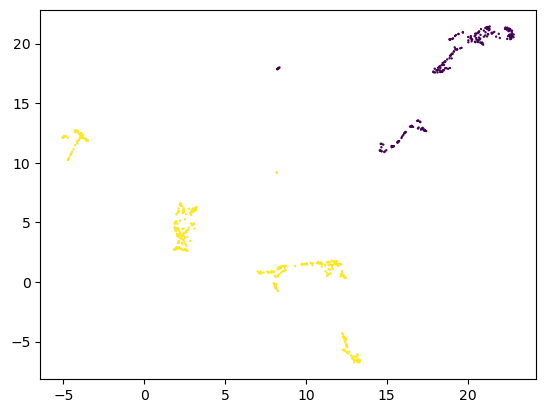

In [104]:
manifold = umap.UMAP().fit(X, y)

X_reduced_2 = manifold.transform(X)

plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [105]:
joblib.dump(manifold, './hor/manifoldflat_p2')

['./hor/manifoldflat_p2']

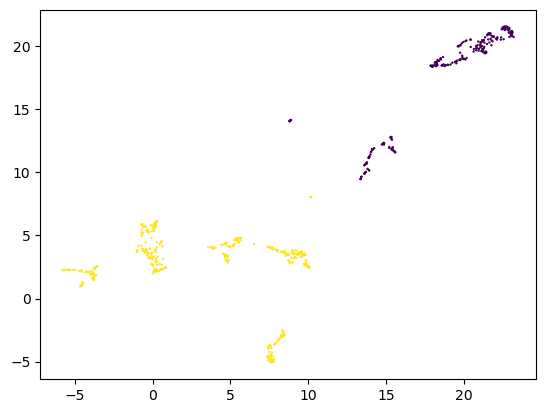

In [114]:
#manifold = umap.UMAP().fit(X, y)

X_reduced_2 = manifold.transform(X)

plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [ ]:
joblib.dump(manifold, './hor/manifoldflat_p3')

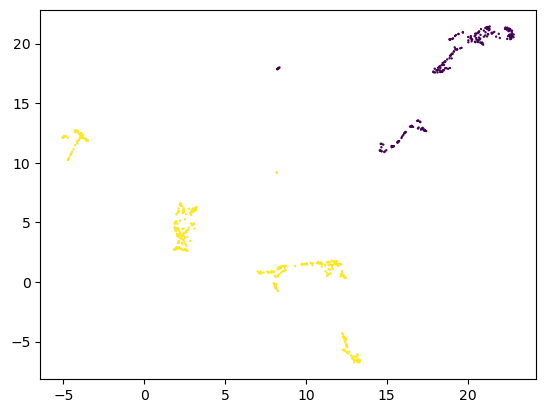

In [113]:
loaded_manifold=joblib.load('./hor/manifoldflat_p2')
fX_reduced_2 = loaded_manifold.transform(X)

plt.scatter(fX_reduced_2[:, 0], fX_reduced_2[:, 1], c=y, s=0.5);

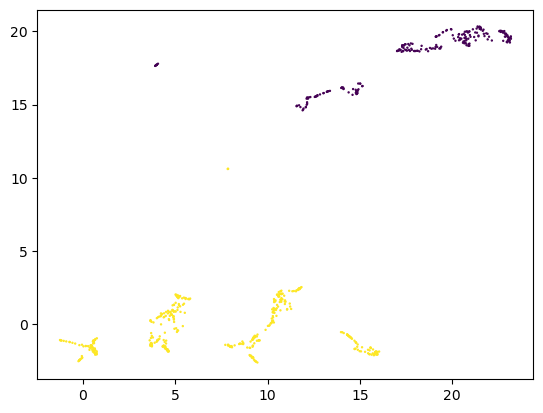

In [120]:
manifold = umap.UMAP().fit(X, y)

X_reduced_2 = manifold.transform(X)

plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [84]:
loaded_manifoldb=joblib.load('./hor/manifold')

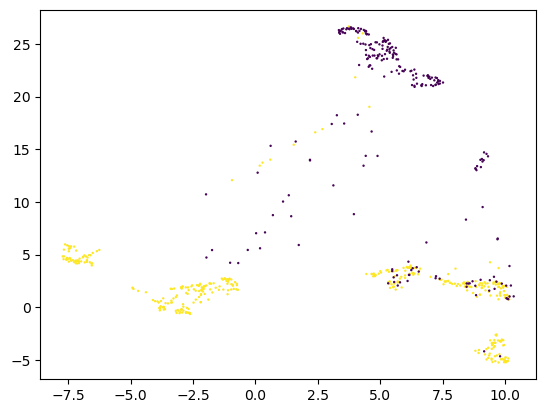

In [86]:
#loaded_manifoldb=joblib.load('./hor/manifold')
X_reduced_2 = loaded_manifoldb.transform(X)

plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [74]:
print(X[0:200,:].shape)

(200, 1024)


In [75]:

Xr2 = manifold.transform(X[0:200,:])

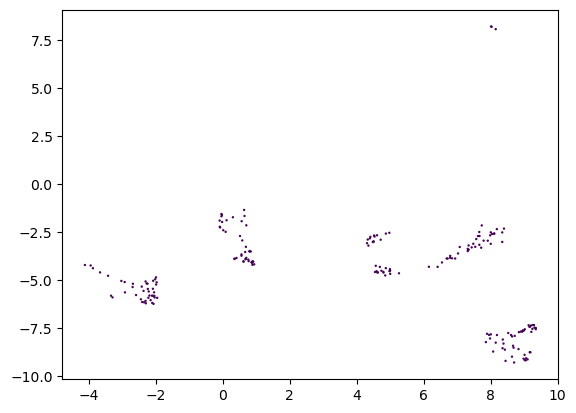

In [77]:

plt.scatter(Xr2[:, 0], Xr2[:, 1], c=y[0:200], s=0.5);

In [ ]:
X=dfc
y=cc
# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
#manifold = umap.fit(X, y)
X_reduced_2 = manifold.transform(X)


In [68]:
from umap.parametric_umap import ParametricUMAP
embedder = ParametricUMAP()


In [ ]:

embedding = embedder.fit_transform(X.copy())

In [62]:
import tensorflow as tf

2024-08-27 09:10:29.652808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 09:10:29.667139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 09:10:29.671661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 09:10:30.705360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [52]:
cc.shape

(645,)

In [47]:
embedding = umap.UMAP(random_state=42).fit_transform(dfc.values)

AttributeError: module 'umap' has no attribute 'UMAP'

In [8]:
    file2 = open('./conv/Masha_p1.txt',"r+", encoding='utf-8')
    tmpr=file2.read()
    true_texts_in_batch.append(' '.join(list(filter(lambda it: it.isalpha(), nltk.wordpunct_tokenize(tmpr)))).lower().replace('ё', 'е'))
    file2.close()

In [448]:
tmpa=' '.join(list(filter(lambda it: it.isalpha(), nltk.wordpunct_tokenize('Рааб аа,ааа')))).lower().replace('ё', 'е')
print(tmpa)

рааб аа ааа


In [449]:
file2 = open(r"Masha_p1.txt","r+") #a-append
print(file2.read())
file2.close()

работа	работа радио 	радио  радость	радость радуга 	радуга  раз	раз рак 	рак  ракета 	ракета  ракетка 	ракетка  раковина 	раковина  рама 	рама  рана	рана ранец 	ранец  рассказ 	рассказ  расческа 	расческа  Рая 	Рая  рожок 	рожок розетка	розетка ромашка 	ромашка робот	робот ровный 	ровный Родина 	Родина рожки 	рожки роза 	роза розовый	розовый рома 	рома рот 	рот роща 	роща рубанок 	рубанок рубашка 	рубашка рубить 	рубить рука 	рука рукав 	рукав рукавица	рукавица румянец	румянец русский	русский русый 	русый русь	русь ручей 	ручей  ручка	ручка ручной 	ручной  рыба 	рыба рыбак 	рыбак рыбный 	рыбный рыжик	рыжик рынок 	рынок рысь 	рысь рыть	рыть арба 	арба арбат 	арбат арбуз 	арбуз арка 	арка аромат 	аромат артист 	артист астра 	астра барабан	барабан баран 	баран баранка 	баранка баржа	баржа бархан 	бархан бархат 	бархат бодрость 	бодрость боровик 	боровик браво 	браво брат	братбрать	брать буран 	буран буратино 	буратино быстрый 	быстрый вёдра 	вёдра вера 	вера воробей 	воробей выдра 	выдра 

In [443]:
#tmp=[]
tmp.append(audio)
tmp

[array([0.        , 0.        , 0.        , ..., 0.00048828, 0.00088501,
        0.00018311], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.00048828, 0.00088501,
        0.00018311], dtype=float32)]

In [14]:
%%time
aw='./conv/Masha_p1.wav'
#aw='./dataset/demo1.wav'
audio, sr = librosa.load(aw, sr=16000)

CPU times: user 42 ms, sys: 18.8 ms, total: 60.9 ms
Wall time: 59.8 ms


In [15]:
true_texts_in_batch=['работа работа радио радио  радость радость радуга радуга раз раз рак рак ракета ракета ракетка ракетка  раковина 	раковина  рама рама  рана рана ранец ранец  рассказ рассказ  расческа расческа  рая рая  рожок 	рожок розетка	розетка ромашка 	ромашка робот	робот ровный 	ровный Родина 	Родина рожки 	рожки роза 	роза розовый	розовый рома 	рома рот 	рот роща 	роща рубанок 	рубанок рубашка 	рубашка рубить 	рубить рука 	рука рукав 	рукав рукавица	рукавица румянец	румянец русский	русский русый 	русый русь	русь ручей 	ручей  ручка	ручка ручной 	ручной  рыба 	рыба рыбак 	рыбак рыбный 	рыбный рыжик	рыжик рынок 	рынок рысь 	рысь рыть	рыть арба 	арба арбат 	арбат арбуз 	арбуз арка 	арка аромат 	аромат артист 	артист астра 	астра барабан	барабан баран 	баран баранка 	баранка баржа	баржа бархан 	бархан бархат 	бархат бодрость 	бодрость боровик 	боровик браво 	браво брат	братбрать	брать буран 	буран буратино 	буратино быстрый 	быстрый вёдра 	вёдра вера 	вера воробей 	воробей выдра 	выдра гараж 	гараж гармонь 	гамонь  гитара 	гитара гора 	гора град 	град грамм 	грамм грамота 	грамота гранат 	гранат грач 	грач детвора 	детвора ']
#true_texts_in_batch=['рак']
sounds_in_batch=[audio]

In [434]:
file2 = open(r"Masha_p1.txt","w+") #a-append
file2.write(true_texts_in_batch[0])
file2.close()

In [430]:
[sounds_in_batch[0],sounds_in_batch[0]]

[array([0.        , 0.        , 0.        , ..., 0.00048828, 0.00088501,
        0.00018311], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.00048828, 0.00088501,
        0.00018311], dtype=float32)]

In [16]:
for snd, txt in zip(sounds_in_batch, true_texts_in_batch):
    print(f'sound.shape = {snd.shape}, text = {txt}')

sound.shape = (2747392,), text = работа работа радио радио  радость радость радуга радуга раз раз рак рак ракета ракета ракетка ракетка  раковина 	раковина  рама рама  рана рана ранец ранец  рассказ рассказ  расческа расческа  рая рая  рожок 	рожок розетка	розетка ромашка 	ромашка робот	робот ровный 	ровный Родина 	Родина рожки 	рожки роза 	роза розовый	розовый рома 	рома рот 	рот роща 	роща рубанок 	рубанок рубашка 	рубашка рубить 	рубить рука 	рука рукав 	рукав рукавица	рукавица румянец	румянец русский	русский русый 	русый русь	русь ручей 	ручей  ручка	ручка ручной 	ручной  рыба 	рыба рыбак 	рыбак рыбный 	рыбный рыжик	рыжик рынок 	рынок рысь 	рысь рыть	рыть арба 	арба арбат 	арбат арбуз 	арбуз арка 	арка аромат 	аромат артист 	артист астра 	астра барабан	барабан баран 	баран баранка 	баранка баржа	баржа бархан 	бархан бархат 	бархат бодрость 	бодрость боровик 	боровик браво 	браво брат	братбрать	брать буран 	буран буратино 	буратино быстрый 	быстрый вёдра 	вёдра вера 	вера воробей 	в

In [17]:
%%time
processed = processor(sounds_in_batch, sampling_rate=16_000,
                      return_tensors="pt", padding="longest")

CPU times: user 53.6 ms, sys: 4.31 ms, total: 57.9 ms
Wall time: 46.6 ms


In [8]:
%%time
with torch.no_grad():
    logits = model(processed.input_values, attention_mask=processed.attention_mask).logits

CPU times: user 2.3 s, sys: 32.3 ms, total: 2.33 s
Wall time: 616 ms


In [13]:
%%time
with torch.no_grad():
    logits = model(processed2, attention_mask=processed2am).logits

CPU times: user 146 ms, sys: 80.5 ms, total: 227 ms
Wall time: 248 ms


In [25]:
#%%time
#with torch.no_grad():
#    logits = model(processed2, attention_mask=processed2am).logits

In [6]:
%%time
with torch.no_grad():
    logits = model(processed.input_values, attention_mask=processed.attention_mask).logits

CPU times: user 25min 30s, sys: 3min 21s, total: 28min 51s
Wall time: 7min 56s


In [33]:
feat_extract_output_lengths = model._get_feat_extract_output_lengths(processed.attention_mask.sum(dim=1)).numpy()

In [9]:
device = "cuda:0"
model     = model.to(device)

In [46]:
device = "cpu"
model     = model.to(device)

In [18]:
processed2   = processed.input_values.cuda()
processed2am = processed.attention_mask.cuda()

In [27]:
torch.cuda.empty_cache()
import gc
#del variables
gc.collect()

42

In [24]:
#%%time
#with torch.no_grad():
#    logits2 = model(processed2, attention_mask=processed2am).logits

In [34]:
emission_matrices = []
for sample_idx in range(feat_extract_output_lengths.shape[0]):
    specgram_len = feat_extract_output_lengths[sample_idx]
    new_emission_matrix = torch.log_softmax(
        logits[sample_idx, 0:specgram_len],
        dim=-1
    ).numpy()
    assert len(new_emission_matrix.shape) == 2
    assert new_emission_matrix.shape[0] == specgram_len
    emission_matrices.append(new_emission_matrix)

In [35]:
def get_trellis(emission: np.ndarray, tokens_ids: List[int],
                blank_id: int = 0) -> np.ndarray:
    assert isinstance(emission, np.ndarray)
    assert len(emission.shape) == 2
    num_frame = emission.shape[0]
    num_tokens = len(tokens_ids)
    trellis = np.empty((num_frame + 1, num_tokens + 1), dtype=np.float64)
    trellis[0, 0] = 0
    trellis[1:, 0] = np.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")
    for t in range(num_frame):
        trellis[t + 1, 1:] = np.maximum(
            trellis[t, 1:] + emission[t, blank_id],
            trellis[t, :-1] + emission[t, tokens_ids]
        )
    return trellis

In [36]:
with processor.as_target_processor():
    processedtxt = processor(true_texts_in_batch, padding='longest', return_tensors='pt')
    labels_ = processedtxt.input_ids.masked_fill(
    processedtxt.attention_mask.ne(1),
    -100
)

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [37]:

labels_ = labels_.numpy()
labels = []
for sample_idx in range(labels_.shape[0]):
    new_label_list = []
    for token_idx in range(labels_.shape[1]):
        if labels_[sample_idx, token_idx] < 0:
            break
        new_label_list.append(int(labels_[sample_idx, token_idx]))
    labels.append(new_label_list)
    del new_label_list
del labels_

In [38]:
trellis = get_trellis(emission_matrices[0], labels[0])

In [39]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis: np.ndarray, emission: np.ndarray, tokens_ids: List[int],
              blank_id: int = 0) -> List[Point]:
    j = trellis.shape[1] - 1
    t_start = np.argmax(trellis[:, j])

    path = []
    for t in range(t_start, 0, -1):
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens_ids[j - 1]]

        prob = np.exp(emission[t - 1, tokens_ids[j - 1] if changed > stayed else 0])
        path.append(Point(j - 1, t - 1, prob))
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]

In [40]:
path = backtrack(trellis, emission_matrices[0], labels[0])
for p in path:
    print(p)

Point(token_index=0, time_index=70, score=0.9756361)
Point(token_index=0, time_index=71, score=0.9998473)
Point(token_index=0, time_index=72, score=0.97551733)
Point(token_index=1, time_index=73, score=0.9857297)
Point(token_index=1, time_index=74, score=0.99983394)
Point(token_index=1, time_index=75, score=0.9998462)
Point(token_index=1, time_index=76, score=0.99975103)
Point(token_index=1, time_index=77, score=0.99852633)
Point(token_index=1, time_index=78, score=0.6295591)
Point(token_index=1, time_index=79, score=0.18011835)
Point(token_index=2, time_index=80, score=0.9227925)
Point(token_index=2, time_index=81, score=0.9996947)
Point(token_index=2, time_index=82, score=0.6075231)
Point(token_index=2, time_index=83, score=0.8612411)
Point(token_index=3, time_index=84, score=0.876329)
Point(token_index=3, time_index=85, score=0.9930276)
Point(token_index=3, time_index=86, score=0.9938281)
Point(token_index=3, time_index=87, score=0.99524695)
Point(token_index=3, time_index=88, score

Point(token_index=290, time_index=2476, score=0.99951947)
Point(token_index=290, time_index=2477, score=0.83050305)
Point(token_index=291, time_index=2478, score=0.48858348)
Point(token_index=291, time_index=2479, score=0.8990602)
Point(token_index=291, time_index=2480, score=0.9992379)
Point(token_index=291, time_index=2481, score=0.99968874)
Point(token_index=291, time_index=2482, score=0.99973565)
Point(token_index=291, time_index=2483, score=0.99973303)
Point(token_index=291, time_index=2484, score=0.9997008)
Point(token_index=291, time_index=2485, score=0.99967325)
Point(token_index=291, time_index=2486, score=0.99913883)
Point(token_index=291, time_index=2487, score=0.999278)
Point(token_index=291, time_index=2488, score=0.9994437)
Point(token_index=291, time_index=2489, score=0.99839216)
Point(token_index=292, time_index=2490, score=0.9568327)
Point(token_index=292, time_index=2491, score=0.97932154)
Point(token_index=292, time_index=2492, score=0.99762434)
Point(token_index=292

Point(token_index=596, time_index=5074, score=0.9848798)
Point(token_index=596, time_index=5075, score=0.9841053)
Point(token_index=596, time_index=5076, score=0.68826836)
Point(token_index=596, time_index=5077, score=0.36219102)
Point(token_index=596, time_index=5078, score=0.9951934)
Point(token_index=596, time_index=5079, score=0.9911377)
Point(token_index=596, time_index=5080, score=0.9869804)
Point(token_index=596, time_index=5081, score=0.9838255)
Point(token_index=597, time_index=5082, score=0.011655248)
Point(token_index=597, time_index=5083, score=0.9383997)
Point(token_index=597, time_index=5084, score=0.9564807)
Point(token_index=598, time_index=5085, score=0.009338709)
Point(token_index=598, time_index=5086, score=0.9711015)
Point(token_index=598, time_index=5087, score=0.96865875)
Point(token_index=598, time_index=5088, score=0.98782027)
Point(token_index=599, time_index=5089, score=0.016419316)
Point(token_index=599, time_index=5090, score=0.9638346)
Point(token_index=599

Point(token_index=945, time_index=7604, score=0.9996258)
Point(token_index=945, time_index=7605, score=0.99880064)
Point(token_index=946, time_index=7606, score=0.022555891)
Point(token_index=946, time_index=7607, score=0.9996941)
Point(token_index=946, time_index=7608, score=0.99855953)
Point(token_index=947, time_index=7609, score=0.9871725)
Point(token_index=947, time_index=7610, score=0.9990809)
Point(token_index=947, time_index=7611, score=0.9987257)
Point(token_index=947, time_index=7612, score=0.99641776)
Point(token_index=947, time_index=7613, score=0.980314)
Point(token_index=948, time_index=7614, score=0.88424045)
Point(token_index=948, time_index=7615, score=0.1849377)
Point(token_index=948, time_index=7616, score=0.99933225)
Point(token_index=948, time_index=7617, score=0.9997557)
Point(token_index=948, time_index=7618, score=0.99451077)
Point(token_index=949, time_index=7619, score=0.19879983)
Point(token_index=949, time_index=7620, score=0.99968684)
Point(token_index=949,

In [73]:
labels[0]

[21,
 5,
 6,
 19,
 23,
 5,
 3,
 21,
 5,
 6,
 19,
 23,
 5,
 4,
 21,
 5,
 9,
 13,
 19,
 4,
 3,
 21,
 5,
 9,
 13,
 19,
 4,
 4,
 21,
 5,
 9,
 19,
 22,
 23,
 33,
 3,
 21,
 5,
 9,
 19,
 22,
 23,
 33,
 4,
 21,
 5,
 9,
 24,
 8,
 5,
 4,
 3,
 21,
 5,
 9,
 24,
 8,
 5,
 4,
 4,
 21,
 5,
 12,
 3,
 21,
 5,
 12,
 4,
 21,
 5,
 15,
 4,
 3,
 21,
 5,
 15,
 4,
 4,
 21,
 5,
 15,
 10,
 23,
 5,
 4,
 3,
 21,
 5,
 15,
 10,
 23,
 5,
 4,
 4,
 21,
 5,
 15,
 10,
 23,
 15,
 5,
 4,
 3,
 21,
 5,
 15,
 10,
 23,
 15,
 5,
 4,
 4,
 21,
 5,
 15,
 19,
 7,
 13,
 18,
 5,
 4,
 3,
 21,
 5,
 15,
 19,
 7,
 13,
 18,
 5,
 4,
 4,
 21,
 5,
 17,
 5,
 4,
 3,
 21,
 5,
 17,
 5,
 4,
 4,
 21,
 5,
 18,
 5,
 3,
 21,
 5,
 18,
 5,
 4,
 21,
 5,
 18,
 10,
 27,
 4,
 3,
 21,
 5,
 18,
 10,
 27,
 4,
 4,
 21,
 5,
 22,
 22,
 15,
 5,
 12,
 4,
 3,
 21,
 5,
 22,
 22,
 15,
 5,
 12,
 4,
 4,
 21,
 5,
 22,
 28,
 10,
 22,
 15,
 5,
 4,
 3,
 21,
 5,
 22,
 28,
 10,
 22,
 15,
 5,
 4,
 4,
 3,
 5,
 36,
 4,
 3,
 3,
 5,
 36,
 4,
 4,
 21,
 19,
 11,
 19,
 15,
 4,
 3,
 

In [41]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path: List[Point], tokenized: List[str]) -> List[Segment]:
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                tokenized[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score
            )
        )
        i1 = i2
    return segments

In [45]:
len(path)

8441

In [75]:
for i in range(300):
    print(processor.tokenizer.convert_ids_to_tokens(path[labels[0][i]].token_index))

|
<s>
<s>
<unk>
|
<s>
<s>
|
<s>
<s>
<unk>
|
<s>
<s>
|
<s>
<s>
</s>
<unk>
<s>
<s>
|
<s>
<s>
</s>
<unk>
<s>
<s>
|
<s>
<s>
<unk>
|
|
б
<s>
|
<s>
<s>
<unk>
|
|
б
<s>
|
<s>
<s>
|
<s>
<s>
<s>
<s>
|
<s>
<s>
|
<s>
<s>
<s>
<s>
|
<s>
</s>
<s>
|
<s>
</s>
<s>
|
<s>
<unk>
<s>
<s>
|
<s>
<unk>
<s>
<s>
|
<s>
<unk>
</s>
|
<s>
<s>
<s>
|
<s>
<unk>
</s>
|
<s>
<s>
<s>
|
<s>
<unk>
</s>
|
<unk>
<s>
<s>
<s>
|
<s>
<unk>
</s>
|
<unk>
<s>
<s>
<s>
|
<s>
<unk>
<unk>
<s>
</s>
<unk>
<s>
<s>
<s>
|
<s>
<unk>
<unk>
<s>
</s>
<unk>
<s>
<s>
<s>
|
<s>
<unk>
<s>
<s>
<s>
|
<s>
<unk>
<s>
<s>
<s>
|
<s>
<unk>
<s>
<s>
|
<s>
<unk>
<s>
<s>
|
<s>
<unk>
</s>
а
<s>
<s>
|
<s>
<unk>
</s>
а
<s>
<s>
|
<s>
|
|
<unk>
<s>
</s>
<s>
<s>
|
<s>
|
|
<unk>
<s>
</s>
<s>
<s>
|
<s>
|
а
</s>
|
<unk>
<s>
<s>
<s>
|
<s>
|
а
</s>
|
<unk>
<s>
<s>
<s>
<s>
<s>
б
<s>
<s>
<s>
<s>
б
<s>
<s>
|
<unk>
</s>
<unk>
<unk>
<s>
<s>
|
<unk>
</s>
<unk>
<unk>
<s>
|
<unk>
</s>
</s>
|
<unk>
<s>
<s>
|
<unk>
</s>
</s>
|
<unk>
<s>
<s>
|
<unk>
<unk>
<s>
а
<unk>
<s>
<s>
<s>
|
<u

In [ ]:
for i in 

In [102]:
segments[1].start

73

In [92]:
labels

[[21,
  5,
  6,
  19,
  23,
  5,
  3,
  21,
  5,
  6,
  19,
  23,
  5,
  4,
  21,
  5,
  9,
  13,
  19,
  4,
  3,
  21,
  5,
  9,
  13,
  19,
  4,
  4,
  21,
  5,
  9,
  19,
  22,
  23,
  33,
  3,
  21,
  5,
  9,
  19,
  22,
  23,
  33,
  4,
  21,
  5,
  9,
  24,
  8,
  5,
  4,
  3,
  21,
  5,
  9,
  24,
  8,
  5,
  4,
  4,
  21,
  5,
  12,
  3,
  21,
  5,
  12,
  4,
  21,
  5,
  15,
  4,
  3,
  21,
  5,
  15,
  4,
  4,
  21,
  5,
  15,
  10,
  23,
  5,
  4,
  3,
  21,
  5,
  15,
  10,
  23,
  5,
  4,
  4,
  21,
  5,
  15,
  10,
  23,
  15,
  5,
  4,
  3,
  21,
  5,
  15,
  10,
  23,
  15,
  5,
  4,
  4,
  21,
  5,
  15,
  19,
  7,
  13,
  18,
  5,
  4,
  3,
  21,
  5,
  15,
  19,
  7,
  13,
  18,
  5,
  4,
  4,
  21,
  5,
  17,
  5,
  4,
  3,
  21,
  5,
  17,
  5,
  4,
  4,
  21,
  5,
  18,
  5,
  3,
  21,
  5,
  18,
  5,
  4,
  21,
  5,
  18,
  10,
  27,
  4,
  3,
  21,
  5,
  18,
  10,
  27,
  4,
  4,
  21,
  5,
  22,
  22,
  15,
  5,
  12,
  4,
  3,
  21,
  5,
  22,
  22,
  15,
  5

In [90]:
aaaa=processor.tokenizer.convert_ids_to_tokens( labels[0],  skip_special_tokens=False   )

In [91]:
aaaa

['р',
 'а',
 'б',
 'о',
 'т',
 'а',
 '<unk>',
 'р',
 'а',
 'б',
 'о',
 'т',
 'а',
 '|',
 'р',
 'а',
 'д',
 'и',
 'о',
 '|',
 '<unk>',
 'р',
 'а',
 'д',
 'и',
 'о',
 '|',
 '|',
 'р',
 'а',
 'д',
 'о',
 'с',
 'т',
 'ь',
 '<unk>',
 'р',
 'а',
 'д',
 'о',
 'с',
 'т',
 'ь',
 '|',
 'р',
 'а',
 'д',
 'у',
 'г',
 'а',
 '|',
 '<unk>',
 'р',
 'а',
 'д',
 'у',
 'г',
 'а',
 '|',
 '|',
 'р',
 'а',
 'з',
 '<unk>',
 'р',
 'а',
 'з',
 '|',
 'р',
 'а',
 'к',
 '|',
 '<unk>',
 'р',
 'а',
 'к',
 '|',
 '|',
 'р',
 'а',
 'к',
 'е',
 'т',
 'а',
 '|',
 '<unk>',
 'р',
 'а',
 'к',
 'е',
 'т',
 'а',
 '|',
 '|',
 'р',
 'а',
 'к',
 'е',
 'т',
 'к',
 'а',
 '|',
 '<unk>',
 'р',
 'а',
 'к',
 'е',
 'т',
 'к',
 'а',
 '|',
 '|',
 'р',
 'а',
 'к',
 'о',
 'в',
 'и',
 'н',
 'а',
 '|',
 '<unk>',
 'р',
 'а',
 'к',
 'о',
 'в',
 'и',
 'н',
 'а',
 '|',
 '|',
 'р',
 'а',
 'м',
 'а',
 '|',
 '<unk>',
 'р',
 'а',
 'м',
 'а',
 '|',
 '|',
 'р',
 'а',
 'н',
 'а',
 '<unk>',
 'р',
 'а',
 'н',
 'а',
 '|',
 'р',
 'а',
 'н',
 'е',
 'ц',
 '

In [43]:
segments = merge_repeats(
    path=path,
    tokenized=processor.tokenizer.convert_ids_to_tokens(
        labels[0],
        skip_special_tokens=False
    )
)
for seg in segments:
    print(seg)

р	(0.98): [   70,    73)
а	(0.83): [   73,    80)
б	(0.85): [   80,    84)
о	(0.97): [   84,    90)
т	(0.80): [   90,    95)
а	(0.92): [   95,    99)
|	(0.95): [   99,   127)
р	(0.48): [  127,   129)
а	(0.85): [  129,   137)
б	(0.76): [  137,   141)
о	(0.89): [  141,   148)
т	(0.82): [  148,   154)
а	(0.88): [  154,   158)
|	(0.99): [  158,   187)
р	(0.99): [  187,   191)
а	(0.96): [  191,   199)
д	(0.67): [  199,   202)
и	(1.00): [  202,   208)
о	(0.94): [  208,   213)
|	(0.99): [  213,   247)
р	(0.60): [  247,   250)
а	(0.95): [  250,   258)
д	(0.80): [  258,   261)
и	(0.98): [  261,   267)
о	(0.98): [  267,   273)
|	(0.96): [  273,   297)
р	(0.98): [  297,   301)
а	(0.89): [  301,   310)
д	(0.81): [  310,   313)
о	(0.97): [  313,   318)
с	(0.89): [  318,   323)
т	(0.00): [  323,   324)
ь	(0.04): [  324,   325)
|	(0.95): [  325,   346)
р	(0.74): [  346,   350)
а	(0.91): [  350,   358)
д	(0.77): [  358,   360)
о	(0.87): [  360,   366)
с	(0.86): [  366,   373)
т	(0.01): [  373,   374)


In [44]:
labels

[[21,
  5,
  6,
  19,
  23,
  5,
  3,
  21,
  5,
  6,
  19,
  23,
  5,
  4,
  21,
  5,
  9,
  13,
  19,
  4,
  3,
  21,
  5,
  9,
  13,
  19,
  4,
  4,
  21,
  5,
  9,
  19,
  22,
  23,
  33,
  3,
  21,
  5,
  9,
  19,
  22,
  23,
  33,
  4,
  21,
  5,
  9,
  24,
  8,
  5,
  4,
  3,
  21,
  5,
  9,
  24,
  8,
  5,
  4,
  4,
  21,
  5,
  12,
  3,
  21,
  5,
  12,
  4,
  21,
  5,
  15,
  4,
  3,
  21,
  5,
  15,
  4,
  4,
  21,
  5,
  15,
  10,
  23,
  5,
  4,
  3,
  21,
  5,
  15,
  10,
  23,
  5,
  4,
  4,
  21,
  5,
  15,
  10,
  23,
  15,
  5,
  4,
  3,
  21,
  5,
  15,
  10,
  23,
  15,
  5,
  4,
  4,
  21,
  5,
  15,
  19,
  7,
  13,
  18,
  5,
  4,
  3,
  21,
  5,
  15,
  19,
  7,
  13,
  18,
  5,
  4,
  4,
  21,
  5,
  17,
  5,
  4,
  3,
  21,
  5,
  17,
  5,
  4,
  4,
  21,
  5,
  18,
  5,
  3,
  21,
  5,
  18,
  5,
  4,
  21,
  5,
  18,
  10,
  27,
  4,
  3,
  21,
  5,
  18,
  10,
  27,
  4,
  4,
  21,
  5,
  22,
  22,
  15,
  5,
  12,
  4,
  3,
  21,
  5,
  22,
  22,
  15,
  5

In [43]:
path

[Point(token_index=0, time_index=70, score=0.9756361),
 Point(token_index=0, time_index=71, score=0.9998473),
 Point(token_index=0, time_index=72, score=0.97551733),
 Point(token_index=1, time_index=73, score=0.9857297),
 Point(token_index=1, time_index=74, score=0.99983394),
 Point(token_index=1, time_index=75, score=0.9998462),
 Point(token_index=1, time_index=76, score=0.99975103),
 Point(token_index=1, time_index=77, score=0.99852633),
 Point(token_index=1, time_index=78, score=0.6295591),
 Point(token_index=1, time_index=79, score=0.18011835),
 Point(token_index=2, time_index=80, score=0.9227925),
 Point(token_index=2, time_index=81, score=0.9996947),
 Point(token_index=2, time_index=82, score=0.6075231),
 Point(token_index=2, time_index=83, score=0.8612411),
 Point(token_index=3, time_index=84, score=0.876329),
 Point(token_index=3, time_index=85, score=0.9930276),
 Point(token_index=3, time_index=86, score=0.9938281),
 Point(token_index=3, time_index=87, score=0.99524695),
 Poin

In [106]:
segments[0]

р	(0.98): [   70,    73)

In [107]:
len(segments)

1140

In [114]:
for i in range(70,73):
    print(i)

70
71
72


In [144]:
tmpi

8502

In [44]:
rnumers=[]
bnumers=[]
for index in range(len(segments)):
    #print(f' aa1 {aa1} aa2 {aa2}')
    if segments[index].label=='р':
        for tmpi in range(segments[index].start,segments[index].end):
          if segments[index].score>0.80 :
            rnumers.append(tmpi)   
          else:
            bnumers.append(tmpi)   
    print(segments[index])

р	(0.98): [   70,    73)
а	(0.83): [   73,    80)
б	(0.85): [   80,    84)
о	(0.97): [   84,    90)
т	(0.80): [   90,    95)
а	(0.92): [   95,    99)
|	(0.95): [   99,   127)
р	(0.48): [  127,   129)
а	(0.85): [  129,   137)
б	(0.76): [  137,   141)
о	(0.89): [  141,   148)
т	(0.82): [  148,   154)
а	(0.88): [  154,   158)
|	(0.99): [  158,   187)
р	(0.99): [  187,   191)
а	(0.96): [  191,   199)
д	(0.67): [  199,   202)
и	(1.00): [  202,   208)
о	(0.94): [  208,   213)
|	(0.99): [  213,   247)
р	(0.60): [  247,   250)
а	(0.95): [  250,   258)
д	(0.80): [  258,   261)
и	(0.98): [  261,   267)
о	(0.98): [  267,   273)
|	(0.96): [  273,   297)
р	(0.98): [  297,   301)
а	(0.89): [  301,   310)
д	(0.81): [  310,   313)
о	(0.97): [  313,   318)
с	(0.89): [  318,   323)
т	(0.00): [  323,   324)
ь	(0.04): [  324,   325)
|	(0.95): [  325,   346)
р	(0.74): [  346,   350)
а	(0.91): [  350,   358)
д	(0.77): [  358,   360)
о	(0.87): [  360,   366)
с	(0.86): [  366,   373)
т	(0.01): [  373,   374)


In [147]:
rnumers

[70,
 71,
 72,
 187,
 188,
 189,
 190,
 297,
 298,
 299,
 300,
 391,
 392,
 393,
 394,
 488,
 489,
 490,
 594,
 595,
 596,
 597,
 598,
 690,
 691,
 867,
 868,
 869,
 930,
 931,
 932,
 933,
 934,
 935,
 936,
 937,
 938,
 939,
 940,
 941,
 942,
 943,
 944,
 945,
 946,
 947,
 948,
 949,
 950,
 951,
 952,
 953,
 954,
 955,
 956,
 957,
 958,
 959,
 1018,
 1019,
 1020,
 1021,
 1221,
 1222,
 1223,
 1224,
 1225,
 1324,
 1325,
 1326,
 1327,
 1328,
 1441,
 1442,
 1443,
 1752,
 1753,
 1754,
 1851,
 1852,
 1853,
 2068,
 2069,
 2070,
 2071,
 2072,
 2073,
 2131,
 2132,
 2133,
 2134,
 2135,
 2136,
 2137,
 2176,
 2177,
 2178,
 2179,
 2180,
 2473,
 2474,
 2475,
 2476,
 2477,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2568,
 2569,
 2570,
 2571,
 2670,
 2671,
 2672,
 2673,
 2674,
 2810,
 2811,
 2812,
 2813,
 2814,
 2815,
 2816,
 2817,
 2849,
 2850,
 2851,
 2852,
 2853,
 3171,
 3172,
 3173,
 3405,
 3406,
 4186,
 4187,
 4277,
 4278,
 4304,
 4305,
 4306,
 4307,
 4308,
 4309,
 4310,
 4311,
 431

In [354]:
bnumers

[127,
 128,
 247,
 248,
 249,
 346,
 347,
 348,
 349,
 441,
 442,
 443,
 541,
 542,
 649,
 650,
 651,
 737,
 738,
 739,
 740,
 1076,
 1077,
 1078,
 1079,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1176,
 1177,
 1178,
 1272,
 1273,
 1386,
 1387,
 1495,
 1540,
 1541,
 1542,
 1594,
 1595,
 1596,
 1799,
 1800,
 1903,
 1904,
 1957,
 1958,
 1959,
 2015,
 2016,
 2230,
 2378,
 2379,
 2380,
 2431,
 2628,
 2712,
 2713,
 2714,
 2715,
 2764,
 2765,
 2906,
 2943,
 2944,
 3008,
 3060,
 3061,
 3118,
 3119,
 3258,
 3259,
 3544,
 3591,
 3592,
 3642,
 3688,
 3689,
 3744,
 3793,
 3794,
 3855,
 3911,
 3912,
 3958,
 3959,
 3960,
 4009,
 4010,
 4011,
 4056,
 4057,
 4058,
 4102,
 4103,
 4145,
 4146,
 4147,
 4148,
 4236,
 4237,
 4426,
 4427,
 4527,
 4613,
 4715,
 4910,
 4992,
 5082,
 5083,
 5084,
 5167,
 5168,
 5169,
 5170,
 5171,
 5172,
 5173,
 5258,
 5259,
 5260,
 5261,
 5262,
 5263,
 5577,
 5578,
 5579,
 5580,
 5581,
 5582,
 5583,
 5584,
 5757,
 5758,
 5803,
 5804,
 5805,
 5806,
 5892,
 5893,
 5894,
 5895,

In [25]:
with torch.no_grad():
    ts = model(processed.input_values, attention_mask=processed.attention_mask, output_hidden_states=True, return_dict=True)

res = model(input_values, attention_mask=attention_mask, labels=labels, output_hidden_states=True, return_dict=True)

In [26]:
ts

CausalLMOutput(loss=None, logits=tensor([[[  3.9681, -19.2303, -19.5649,  ...,  -8.9581,  -9.5567,  -8.1932],
         [  4.0585, -19.3284, -19.6767,  ...,  -9.0936,  -9.2782,  -8.0763],
         [  4.0972, -19.3582, -19.7214,  ...,  -9.0984,  -9.2160,  -8.0419],
         ...,
         [  3.3752, -19.0009, -19.3626,  ...,  -8.4200,  -9.9651,  -8.9114],
         [  3.4344, -18.9878, -19.3818,  ...,  -8.5017, -10.0419,  -9.0805],
         [  4.3199, -19.7343, -20.1086,  ...,  -8.9186,  -8.5219,  -7.2248]]]), hidden_states=(tensor([[[-0.9430,  1.1750,  2.5174,  ...,  0.6820,  2.5016,  3.8418],
         [-0.9362,  1.1923,  2.7552,  ...,  0.7028,  2.4836,  3.8597],
         [-0.9272,  1.2003,  2.6008,  ...,  0.7104,  2.5428,  3.8788],
         ...,
         [-1.2810, -0.6072,  5.3468,  ..., -1.5734, -1.5662,  1.1791],
         [ 0.6906,  0.0564,  4.1525,  ...,  0.6226, -1.6269, -1.4777],
         [ 0.5512, -0.8892,  3.5452,  ..., -1.0141,  0.6680,  0.5121]]]), tensor([[[-0.5161,  3.1737, -1

In [28]:
last_hidden_state = ts.hidden_states[-1]

In [29]:
last_hidden_state

(tensor([[[-0.9430,  1.1750,  2.5174,  ...,  0.6820,  2.5016,  3.8418],
          [-0.9362,  1.1923,  2.7552,  ...,  0.7028,  2.4836,  3.8597],
          [-0.9272,  1.2003,  2.6008,  ...,  0.7104,  2.5428,  3.8788],
          ...,
          [-1.2810, -0.6072,  5.3468,  ..., -1.5734, -1.5662,  1.1791],
          [ 0.6906,  0.0564,  4.1525,  ...,  0.6226, -1.6269, -1.4777],
          [ 0.5512, -0.8892,  3.5452,  ..., -1.0141,  0.6680,  0.5121]]]),
 tensor([[[-0.5161,  3.1737, -1.8155,  ...,  0.8032,  0.2001,  0.1520],
          [-0.6518,  2.2581, -1.6681,  ...,  1.0673,  1.0678,  0.4990],
          [-0.5718,  1.4164, -2.1551,  ...,  1.0669,  1.2850,  0.5684],
          ...,
          [-0.8180,  0.8757,  1.3740,  ..., -1.6280, -2.2814, -1.6484],
          [-0.4609,  3.7925, -0.8955,  ...,  0.4030, -2.8011, -4.9362],
          [-0.9969,  2.7635, -1.5068,  ..., -1.3978,  0.6169, -3.8428]]]),
 tensor([[[-0.8736,  3.4900, -6.3747,  ...,  1.0833, -0.4862, -1.5737],
          [-0.6150,  1.8406,

In [47]:
%%time
with torch.no_grad():
    ts = model(processed.input_values, attention_mask=processed.attention_mask, output_hidden_states=True)

CPU times: user 25min 24s, sys: 3min 16s, total: 28min 41s
Wall time: 7min 52s


In [51]:
len(last_hidden_state)

2

In [50]:
last_hidden_state = ts.hidden_states[-1]

In [52]:
last_hidden_state.shape

torch.Size([2, 8585, 1024])

In [41]:
last_hidden_state[0,1].shape

torch.Size([1024])

In [42]:
import umap

In [99]:
aa=[1,3,6]
for aa1, aa2 in enumerate(aa):
    print(f' aa1 {aa1} aa2 {aa2}')

 aa1 0 aa2 1
 aa1 1 aa2 3
 aa1 2 aa2 6


In [ ]:
 last_hidden_state.shape last_hidden_state[0,1].shape

In [119]:
len(rnumers)

645

In [121]:
import umap
import pandas as pd
import numpy as np

In [149]:
rhs=[]
for i in rnumers:
    #print(i)
    rhs.append(last_hidden_state[0,i].numpy())
bhs=[]
for i in bnumers:
    #print(i)
    bhs.append(last_hidden_state[0,i].numpy())
    
rdf=pd.DataFrame(rhs)
bdf=pd.DataFrame(bhs)

In [127]:
lhs

[array([-0.00910598,  0.49058095, -0.03885887, ..., -0.20376919,
         0.14623046, -0.39103678], dtype=float32),
 array([ 0.39174277,  0.63862   , -0.0529312 , ...,  0.09069154,
         0.6291361 ,  0.05230365], dtype=float32),
 array([ 0.0896443 ,  0.6886864 , -0.02302818, ...,  0.05645294,
         0.5130443 ,  0.19605596], dtype=float32),
 array([ 0.0249102 ,  0.33895433,  0.02925072, ..., -0.01211118,
         0.20739791,  0.07641865], dtype=float32),
 array([0.10066943, 0.35375208, 0.00312732, ..., 0.01328212, 0.07482612,
        0.03882409], dtype=float32),
 array([-0.10323197,  0.29285613,  0.05707927, ..., -0.08574887,
        -0.03686261, -0.28557274], dtype=float32),
 array([ 0.25158694,  0.664096  , -0.08126919, ..., -0.05522847,
         0.43190116, -0.08399842], dtype=float32),
 array([ 0.5970477 ,  0.7362173 , -0.04842523, ...,  0.01348069,
         0.5000942 ,  0.12065868], dtype=float32),
 array([ 0.12296075,  0.70212084, -0.00287091, ..., -0.04672647,
         0.49

In [150]:
rdf=pd.DataFrame(rhs)
bdf=pd.DataFrame(bhs)

In [156]:
rdf['a']=1
bdf['a']=0

In [162]:
rdf.shape

(409, 1025)

In [163]:
bdf.shape

(236, 1025)

In [157]:
df=pd.concat([rdf, bdf], ignore_index=True)
dfc = df.drop('a', axis=1)
#df.drop('column_name', axis=1, inplace=True)
cc=df['a']

In [159]:
dfc = df.drop('a', axis=1)
#df.drop('column_name', axis=1, inplace=True)

In [166]:
cc=df['a']

In [167]:
cc.shape

(645,)

In [168]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [169]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(dfc.copy())

In [171]:
manifold = umap.UMAP().fit(X, cc)
X_reduced = manifold.transform(X)

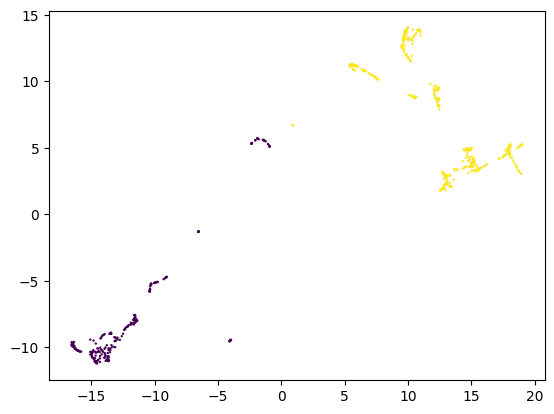

In [173]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cc, s=0.5);

/home/i/j/j/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (645). n_quantiles is set to n_samples.
  warnings.warn(


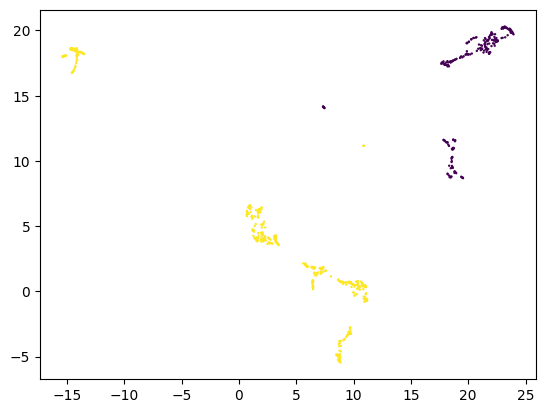

In [175]:
from sklearn.preprocessing import QuantileTransformer
X=dfc
y=cc
# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)


# Plot the results
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);


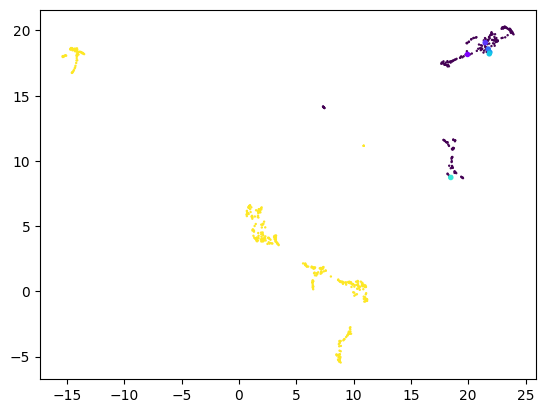

In [427]:
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);
a=409+164
b=409+170
plt.scatter(X_reduced_2[0+a:b, 0], X_reduced_2[0+a:b, 1], c=colors[0:b-a], s=9,marker='o');
#plt.scatter(X_reduced_2[409+0:409+3, 0], X_reduced_2[409+0:409+3, 1], c=colors[300:300+3], s=5,marker='o');

In [177]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 408))
#0:408 645 409+236


In [381]:
colors = cm.rainbow(np.linspace(0, 1, 15))

In [ ]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

In [158]:
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,a
0,-0.009106,0.490581,-0.038859,-0.069540,0.260262,0.207677,-0.111121,-0.034914,-0.130067,0.160332,...,0.324688,0.539073,-0.057617,0.061762,0.190517,0.179151,-0.203769,0.146230,-0.391037,1
1,0.391743,0.638620,-0.052931,-0.117685,0.386741,0.179176,0.041257,-0.005200,0.080361,0.118376,...,0.042322,0.698960,-0.174441,-0.024202,0.516423,0.210190,0.090692,0.629136,0.052304,1
2,0.089644,0.688686,-0.023028,-0.105024,0.412309,0.161274,0.276501,0.047542,0.024896,0.133568,...,-0.258044,0.329555,0.069076,0.076048,0.656487,0.029328,0.056453,0.513044,0.196056,1
3,-0.103232,0.292856,0.057079,-0.046627,0.148330,0.122590,-0.015902,-0.024944,-0.168590,0.085079,...,0.167885,0.195027,0.007220,-0.023980,0.279276,0.101257,-0.085749,-0.036863,-0.285573,1
4,0.251587,0.664096,-0.081269,-0.092147,0.393950,0.196995,-0.068551,0.028803,-0.030345,0.130063,...,0.363353,0.319217,-0.158630,-0.056021,0.595007,0.112306,-0.055228,0.431901,-0.083998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,0.063124,0.211240,-0.006982,-0.042027,0.149295,0.226370,0.274526,0.052123,0.180725,0.119449,...,-0.697310,0.233760,0.012693,-0.144401,0.168185,-0.090804,0.091731,0.389195,0.115263,0
641,0.174947,0.197652,-0.098415,-0.051773,0.266188,0.262195,0.317760,0.104404,0.322005,0.195628,...,-0.556370,0.205846,-0.016733,-0.114216,-0.207831,0.032686,0.225625,0.393870,0.045883,0
642,-0.166864,0.295401,-0.041641,-0.038916,0.229105,0.168220,0.327161,0.128033,0.303966,0.101157,...,-0.543878,0.212121,0.063182,-0.016424,0.166154,-0.193540,0.112361,0.279755,0.089781,0
643,0.210833,0.460039,-0.106424,-0.073843,0.350789,0.224762,0.293892,0.130800,0.307521,0.180637,...,-0.454594,0.242172,0.033086,0.011914,0.124631,0.006354,0.408130,0.364568,0.190186,0


#!pip uninstall umap --yes
!pip install umap-learn

In [135]:
import umap.umap_ as umap

/home/i/j/j/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/i/j/j/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/i/j/j/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword arg

https://stackoverflow.com/questions/57242208/how-to-resolve-the-error-module-umap-has-no-attribute-umap-i-tried-installi
https://www.reneshbedre.com/blog/umap-in-python.html
https://itsourcecode.com/attributeerror/attributeerror-module-umap-has-no-attribute-umap-solved/

In [160]:
embedding = umap.UMAP(random_state=42).fit_transform(dfc.values)

In [161]:
embedding.shape

(645, 2)

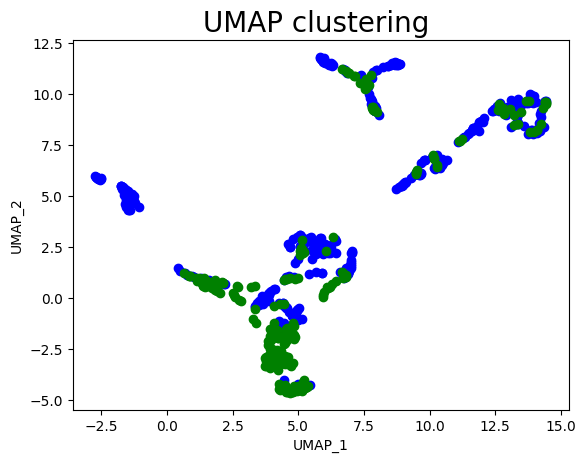

In [165]:
import matplotlib.pyplot as plt

plt.scatter(embedding[0:408, 0], embedding[0:408:, 1],color='blue')
plt.scatter(embedding[409:409+236, 0], embedding[409:409+236:, 1],color='green')
plt.title('UMAP clustering ', fontsize=20)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.show()
#color=['red','green','blue']

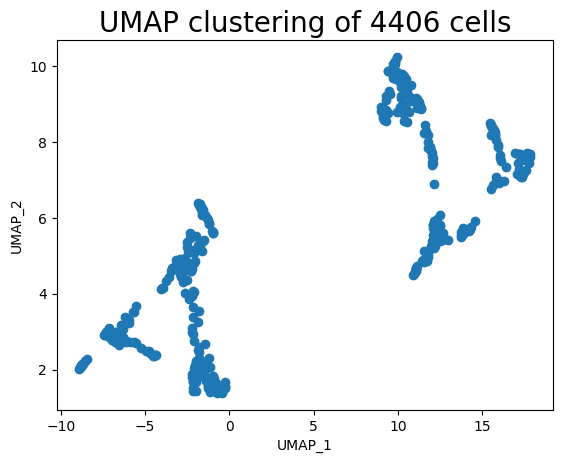

In [152]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('UMAP clustering of 4406 cells', fontsize=20)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.show()

In [142]:
from sklearn.decomposition import PCA
pembedding = PCA(n_components=3).fit_transform(dataframe.values)

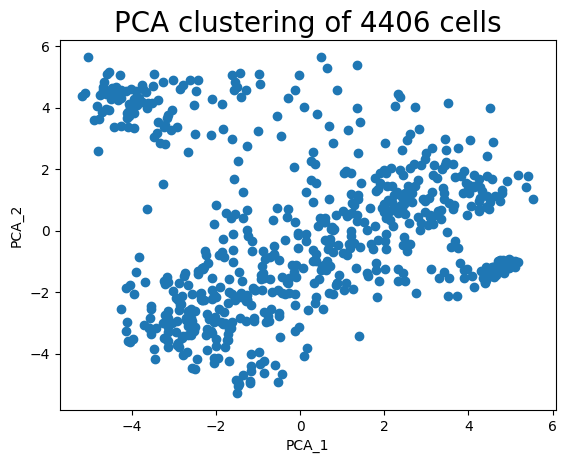

In [143]:
plt.scatter(pembedding[:, 0], pembedding[:, 1])
plt.title('PCA clustering of 4406 cells', fontsize=20)
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()